In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
# {"grid.color": ".6", "grid.linestyle": ":"}
sns.set(font_scale = 1.1)
sns.set_style(style = "white")

In [2]:
t_unet_per_vox = 28.00 # nanoseconds

In [3]:
def get_df(ntheta, n, nz, tag = "fbp"):
    df = pd.read_csv(f'/data02/MyArchive/aisteer_3Dencoders/tmp_data/time_logs/{tag}_times_n{n}_ntheta{ntheta}_nc{nz}.csv')
    if "t_backproj" in df.columns:
        df.rename(columns = {"t_backproj":"t_bp"}, inplace = True)
    
    df['${1/r}$'] = 1.0/df['r_fac']
    df['t_fbp_gpu'] = df['t_filt'] + df['t_mask'] + df['t_bp']
    df['t_fbp'] = df['t_cpu2gpu'] + df['t_fbp_gpu'] + df['t_gpu2cpu']
    df['speedup-fbp-gpu'] = df['t_fbp_gpu'].iloc[-1]/df['t_fbp_gpu']
    df['speedup-bp'] = df['t_bp'].iloc[-1]/df['t_bp']
    df['speedup-fbp'] = df['t_fbp'].iloc[-1]/df['t_fbp']
    df["t_seg"] = df['r_fac']*n*n*nz*t_unet_per_vox*1.0e-6
    df["t_rec"] = df["t_seg"] + df["t_fbp"]
    df['speedup-rec'] = df['t_rec'].iloc[-1]/df['t_rec']   

    return df

In [4]:
def speedup_curve(df, ax, nz_full, axis_labels = False):
    labels = ['${1/r}$', 'speedup-bp', 'speedup-fbp-gpu', 'speedup-fbp', 'speedup-rec']
    colors = ['orange', 'red', 'blue', 'green', 'black']
    markers = ['--', 'x-', 'o-', '*-', '-^']

    for iplot, label in enumerate(labels):
        ax.plot(df['${1/r}$'], df[label], markers[iplot], color = colors[iplot], label = label)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1,100])
    ax.set_ylim([1,100])
    ax.set_title(f"ntheta = {int(df['ntheta'][0])}, n = {int(df['n'][0])}, nz = {nz_full}", fontweight = "bold")    
    
    if axis_labels:
        ax.legend()
        ax.set_ylabel("computational speed-up")
    ax.set_xlabel("sparsity (${1/r}$)")
    
    return

In [5]:
def time_measurements(df, ax, nz_full, axis_labels = False):
    multiplier = nz_full/df['nz']
    
    labels = ['t_fbp', 't_seg', 't_rec']
    colors = ['red', 'blue', 'green']
    markers = ['x--', 'o--', '*--']

    for iplot, label in enumerate(labels):
        ax.plot(df['${1/r}$'], multiplier*df[label]/1000.0, markers[iplot], color = colors[iplot], label = label)
            
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1,100])
    ax.set_ylim([1,1e4])
    
    if axis_labels:
        ax.legend()
        ax.set_ylabel(f"computation time (seconds)")
    ax.set_xlabel("sparsity (${1/r}$)")
    
    return

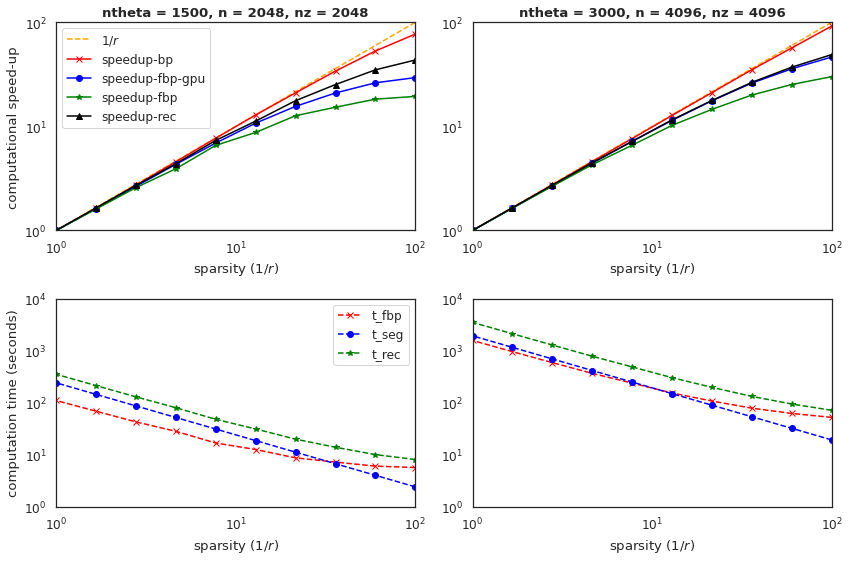

In [6]:
fig, ax = plt.subplots(2,2, figsize = (12,8))
# 2k volume
df = get_df(1500, 2048, 32, tag = "p3d_fbp")
speedup_curve(df, ax[0,0], 2048, axis_labels = True)
time_measurements(df, ax[1,0], 2048, axis_labels = True)
# 4k volume
df = get_df(3000, 4096, 32, tag = "p3d_fbp")
speedup_curve(df, ax[0,1], 4096)
time_measurements(df, ax[1,1], 4096)

fig.tight_layout()

In [7]:
print(get_df(1500, 2048, 32, tag = "p3d_fbp")[['${1/r}$','speedup-rec']].iloc[0])
print(get_df(3000, 4096, 32, tag = "p3d_fbp")[['${1/r}$','speedup-rec']].iloc[0])

${1/r}$        100.000000
speedup-rec     43.442114
Name: 0, dtype: float64
${1/r}$        100.000000
speedup-rec     48.915465
Name: 0, dtype: float64


In [8]:
print(get_df(1500, 2048, 32, tag = "p3d_fbp")['t_rec'].iloc[-1]/32*2048/1000/60)
print(get_df(3000, 4096, 32, tag = "p3d_fbp")['t_rec'].iloc[-1]/32*4096/1000/60)

5.841207798206771
58.15981752888334


In [9]:
58.15981752888334/5.841207798206771

9.956813648495467

In [10]:
df = get_df(1500, 2048, 32, tag = "p3d_fbp")
nz_full = 2048
time_labels = ["t_seg", "t_rec", "t_fbp"]
for label in time_labels:
    multiplier = nz_full/df['nz']
    df[label+"-secs"] = multiplier*df[label]/1000.0   
df[['${1/r}$',"t_seg-secs", "t_rec-secs", "t_fbp-secs"]]

,${1/r}$,t_seg-secs,t_rec-secs,t_fbp-secs
0,100.000000,2.405182,8.067574,5.662392
1,59.948425,4.012085,10.033522,6.021437
2,35.938137,6.692561,13.890300,7.197739
3,21.544347,11.163864,19.845918,8.682054
4,12.915497,18.622448,31.188964,12.566516
5,7.742637,31.064116,47.799110,16.734994
6,4.641589,51.818069,79.888967,28.070899
7,2.782559,86.437748,129.081241,42.643493
8,1.668101,144.186854,212.559779,68.372925
9,1.000000,240.518169,350.472468,109.954299
